# SPDC Simulation by QuTip

Quantum optics relies on a reliable source of single photons and entangled photon pairs.  A typical source of these photons is spontaneous parametric down-conversion (SPDC).  All of the quantum optics experimental lab modules in this class rely on SPDC.  We can model the SPDC process and the squeezed light it generates via the formalism of the degenerate parametric amplifier. The code below is meant to enrich your understanding of the SPDC process.

In [2]:
!pip install qutip

from qutip import *

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from numpy import *
# install QuTip


### Operators and Hamiltonian

The SPDC process works by driving a nonlinear crystal with strong light at a pump frequency $\omega_p$.  One photon of the pump light is then spontaneously converted into two photons $\omega_s$ and $\omega_i$, which refer to the signal and idler modes respectively.  This naming convention was developed to describe parametric amplfiers where one wanted to amplify a weak signal using a strong pump.  Energy conservation requires that this also corresponds with the growth of an idler wave, and you have that $\omega_p = \omega_s + \omega_i$.  In the SPDC process we are concerned with the spontaneous generation of the signal and idler.  These occupy mo modes as $a$ and $b$ respectively.   

The parametric amplification occurs due to a nonlinear coupling between the fields of the pump, signal, and idler waves.  The coefficient describing the strength of this coupling is the nonlinear coefficient $\chi_2$, which is in general complex, but given freedom in choice of phase, we take it as a positive real number here. 

The coupling Hamiltonian for the SPDC process can be represented as

$$
\hat{H} = -i\hbar(\chi_2 \hat{p}^\dagger \hat{a} \hat{b} - \chi_2 \hat{p} \hat{a}^\dagger \hat{b}^\dagger)\mbox{,}
$$

where $p$ represents the pump mode.  The right part describes the loss of one pump photon resulting in the increase of one photon in modes $a$ and $b$ (the signal and idler).  The left part represents back conversion from signal and idler to a pump photon. 

Given a strong coherent state pump, we can represent its operator with a complex number $\alpha_p$ corresponding to its amplitude.  Doing this  we have the Hamiltonian we want to solve for this exercise as

$$
\begin{aligned}
\hat{H}_{ab} = -i \hbar \frac{\chi}{2} (\hat{a} \hat{b} - \hat{a}^{\dagger} \hat{b}^{\dagger})
\end{aligned}
$$

where we define

$$
\chi \equiv \frac{2 \chi_2 |\alpha_p|}{\hbar}.
$$

Here, we explicitly factored out the $\hbar$ term to simplify the subsequent math since that $\hbar$ will be canceled by the $\hbar$ in the denominator of the time dependent Schrodinger equation, $\frac{\partial}{\partial t} |\psi(t)\rangle = -\frac{i}{\hbar} H |\psi(t)\rangle$.  By default, the unit of time in Qutip is set to dimensionless, so $\hbar$ is used to convert between dimensionless time and physical time.

In the following code, the `tensor()` function is used to create composite operators that act on the joint Hilbert space of the two modes. The `destroy()` and `num()` functions create the annihilation and number operators, respectively.

In [3]:
#Constants
hbar=6.67e-34/(2*pi) #Planck's reduced constant
eps0=8.85e-12 # permittivity of free space
c=3e8 # speed of light

#Parameters
phase_matching_bandwidth=1e13 # approximate in Hz
n_refr = 2.2 # refractive index of the crystal
beam_power=1e-2 # in Watts
beam_area=1e-5**2 # in m^2
pump_intensity=beam_power/beam_area
alpha_p = pow(2*pump_intensity/(c*eps0*n_refr),1/2)

#presentation parameters
plot_fontsize=12

#print(alpha_p)
chi2=2.7e-12 # (2.7 pm/V according to https://www.unitedcrystals.com/BBOProp.html) 
#chi = 0.2
chi = 2*chi2*alpha_p/hbar
print(chi*hbar)
N1 = 10
N2 = 10


# definitions of operators 
a  = tensor(destroy(N1), qeye(N2))
na = tensor(num(N1),     qeye(N2)) 
b  = tensor(qeye(N1),    destroy(N2))
nb = tensor(qeye(N1),    num(N2)) 

#We obtain the following interaction Hamiltonian on the three fields $$a,b,p$$ after tracing out the pump field 
# the fully quantum 3-wave mixing Hamiltonion would be H_abp = chi2 * (a * b * p.dag() + a.dag() * b.dag() * p)

H0 = 0*a # interaction Hamiltonian before the 3-wave mixing (used for calculating initial state)
Hab = - 1j* hbar *chi * (a * b - a.dag() * b.dag())/2



9.992292869760638e-07


### Initial state and state evolution

In the following, we will: 
* initialize the input state $\ket{\psi_0}$ of modes a and b, which are both in the vacuum state 
* `tlist`: tlist is a list of times that specifies the times at which the system should be evaluated during the evolution. In the example, tlist is created using the numpy function linspace, which generates an array of evenly spaced values over a specified interval. 
* `c_ops` is a list of collapse operators that describe the sources of decoherence and dissipation in the system. Collapse operators represent the interactions of the system with its environment that cause transitions between the energy eigenstates of the system.
* `e_ops` is a python list storing observables. Here, the e_ops list is empty, which means that there are no observables being monitored during the evolution of the system.
* We use the function mesolve from the Qutip library to solve the [quantum master equation ](https://https://en.wikipedia.org/wiki/Quantum_master_equation) to find the time evolution of the system. The function takes as input the Hamiltonian Hab, the initial state `psi0`, the list of times `tlist`, the list of collapse operators c_ops, and the list of observables `e_ops`. The function returns an object output that contains information about the time evolution of the system, such as the states of the system at each time in `tlist`.

In the example, the `c_ops` list is empty, which means that there are no sources of decoherence or dissipation in the system. As a result, the evolution of the system is purely unitary and described by the Hamiltonian $H_{ab}$. 

The following code uses a python dictionary data structure to conveniently store operators and expected values. In anticipation of correlation values to be considered below, we're including those in our dictionary as well.  

In [4]:
# start in the ground (vacuum) state
psi0 = tensor(basis(N1,0), basis(N2,0)) # initial state in the vacuum

# REVISION: to allow for some background light contamination (room lights, fluorescence, etc), let's actually start in a thermal state with mean photon number.
# REVISION2: with thermal state, the code has to do density matrix evolution which is super slow. let's approximate by equally bright coherent state (which is an equally good approximation as there may be some laser background etc)
#rho0= tensor(thermal_dm(N1, background_photons),thermal_dm(N2, background_photons))
#psi0= tensor(displace(N1,sqrt(background_photons)),displace(N2,sqrt(background_photons)))*psi0
#psi0= tensor(displace(N1,sqrt(background_photons)),displace(N2,sqrt(background_photons)))*psi0

theta=0

background_photons=1e-20
#c_ops = [] # c_ops is a list of collapse operators that describe the sources of decoherence and dissipation in the system. Collapse operators represent the interactions of the system with its environment that cause transitions between the energy eigenstates of the system.
n_th = background_photons  # bath temperature in terms of excitation number
c_ops = []# [sqrt((1+n_th)) * a, sqrt(n_th) * a.dag()]

psi0=cos(theta)**2*psi0 +sin(theta)**2 * tensor(displace(N1,sqrt(background_photons)),qeye(N2))*psi0
#rho0 = steadystate(H0, c_ops)


tlist = np.linspace(0, 1000, 1000) # tlist is a list of times that specifies the times at which the system should be evaluated during the evolution. In the example, tlist is created using the numpy function linspace, which generates an array of evenly spaced values over a specified interval.

e_ops = [] # e_ops is a python list storing observables. Here, the e_ops list is empty, which means that there are no observables being monitored during the evolution of the system
psi_out = mesolve(Hab, psi0, tlist, c_ops, e_ops)

ops_dict = {
  "na": a.dag() * a,
  "na_squared": (a.dag() * a)**2,
  "nb": b.dag() * b,
  "nb_squared": (b.dag() * b)**2,
}

expected_vals_dict = {key: np.zeros(len(psi_out.states)) for key in ops_dict.keys()}

for idx, psi in enumerate(psi_out.states):
  for key in ops_dict.keys():
    expected_vals_dict[key][idx] = expect(ops_dict[key], psi)
    

Let's study $|\psi_{out} \rangle$ by plotting four subplots that show the average number of photons in each mode a and b, as well as their fluctuations, as a function of time. The subplots are labeled with the corresponding quantities and the x-axis of all subplots is shared.

max_photon_flux_a=phase_matching_bandwidth * max(<ada>)= 2.5e+06 photons/sec


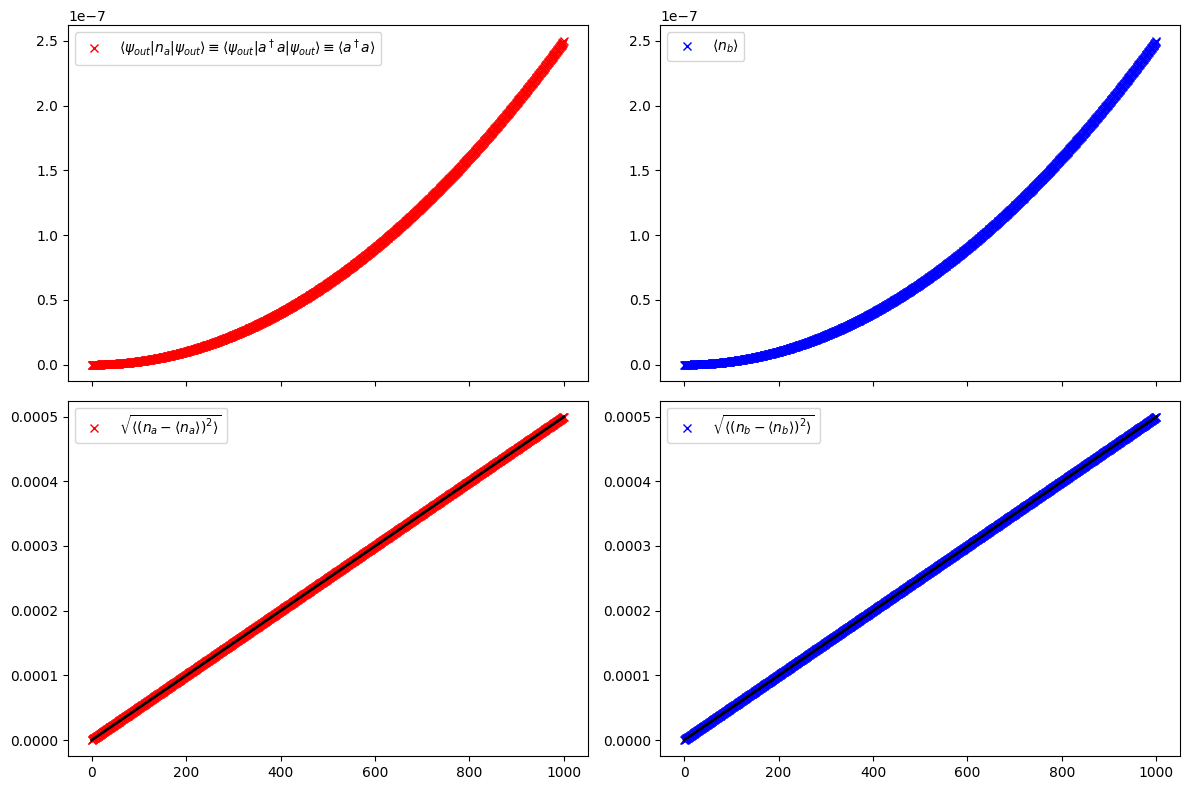

In [5]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12,8))

tlistp=tlist[1:]
lines = [
    [axes[0,0].plot(tlist, expected_vals_dict["na"], 'rx', linewidth=2), r'$\langle \psi_{out}| n_a| \psi_{out} \rangle \equiv \langle \psi_{out}| a^\dagger a | \psi_{out} \rangle \equiv \langle a^\dagger a \rangle$'],
    [axes[0,1].plot(tlist, expected_vals_dict["nb"], 'bx', linewidth=2), r'$\langle n_b \rangle$'],
    [axes[1,0].plot(tlist, np.sqrt(expected_vals_dict["na_squared"] - expected_vals_dict["na"]**2), 'rx', linewidth=2), r'$\sqrt{\langle( n_a - \langle n_a \rangle )^{2} \rangle }$'],
    [axes[1,1].plot(tlist, np.sqrt(expected_vals_dict["nb_squared"] - expected_vals_dict["nb"]**2), 'bx', linewidth=2), r'$\sqrt{\langle( n_b -\langle n_b \rangle)^{2}\rangle }$'],
    [axes[1,0].plot(tlist, np.sqrt(expected_vals_dict["na"]**2+expected_vals_dict["na"]), 'k-', linewidth=2), r'$\sqrt{\langle n_a \rangle + \langle n_a \rangle^{2} }$'],
    [axes[1,1].plot(tlist, np.sqrt(expected_vals_dict["nb_squared"]), 'k-', linewidth=2), r'$\sqrt{\langle n_b \rangle + \langle n_b \rangle^{2} }$']
]

for idx, line in enumerate(lines[:4]):
    line[0][0].set_label(line[1])
    axes[idx//2, idx%2].legend()
    
print("max_photon_flux_a=phase_matching_bandwidth * max(<ada>)= {:.1e} photons/sec".format(phase_matching_bandwidth * max(expected_vals_dict["na"])))

fig.tight_layout()


### State evolution

Next, we will plot the photon distributions of two quantum optical modes a and b at selected times. The time indices are spaced over Ntsamples time steps and are stored in the t_idx_vec list. 

The following subplots show the state evolution (note the plots have shared horizontal and vertical axes). We represent the photon distributions as bar plots on the subplots. 

In [6]:
import ipywidgets as widgets
from IPython.display import display

xmin,xmax = 0,5

def update_plot(t):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))
    psia = ptrace(psi_out.states[t], 0)
    psib = ptrace(psi_out.states[t], 1)
    bar_vals_a = real(psia.diag())
    bar_vals_b = real(psib.diag())
#    max_val = max(bar_vals_a.max(), bar_vals_b.max())
    max_val = max(bar_vals_a[1:].max(), bar_vals_b[1:].max()) # ignore first entry P(0) which is always gonna be large
    axes[0].bar(range(N1), bar_vals_a)
    axes[1].bar(range(N2), bar_vals_b)
    axes[0].set_ylabel('$P(n)$')
    axes[1].set_ylabel('$P(n)$')
    axes[0].set_xlabel('$n_a$')
    axes[1].set_xlabel('$n_b$')
    axes[0].set_yscale('log')
    axes[1].set_yscale('log')
    axes[0].set_ylim(bottom=10**-8, top=bar_vals_a[1]*1.2)
    axes[1].set_ylim(bottom=10**-8, top=bar_vals_a[1]*1.2)
    axes[1].set_xlim(xmin,xmax)
    axes[0].set_xlim(xmin,xmax)

    fig.tight_layout()

t_selector = widgets.FloatSlider(
    min=0,
    max=floor(len(tlist)/2),
    step=1,
    value=0,
    description='Time index:',
    continuous_update=False
)

#display(t_selector)
widgets.interact(update_plot, t=widgets.IntSlider(min=0, max=len(tlist)-1, step=1, value=30))


interactive(children=(IntSlider(value=30, description='t', max=999), Output()), _dom_classes=('widget-interact…

<function __main__.update_plot(t)>

### Photon number statistics

In [7]:
ops_dict.update({
  "ad_ad_a_a": a.dag() * a.dag() * a * a,
  "bd_bd_b_b": b.dag() * b.dag() * b * b,
  "ad_a_bd_b": a.dag() * a * b.dag() * b
  #"ad_a_bd_b": a.dag() * b.dag() * a * b

})
for key in ops_dict:
    expected_vals_dict[key] = np.zeros(len(psi_out.states))


for idx, psi in enumerate(psi_out.states):
  for key in ops_dict:
    expected_vals_dict[key][idx] = expect(ops_dict[key], psi)


The following code updates the dictionary "ops_dict" by adding entries for the observables being monitored during the evolution of the system. These observables are the second-order coherence terms of the two harmonic oscillators, represented by the combinations of creation and annihilation operators. With self-evident notation, these are "ad_ad_a_a", "bd_bd_b_b", and "ad_a_bd_b".

The code then initializes the dictionary "expected_vals_dict" to store the expected values of these observables over time. This is done by creating an array of zeros with length equal to the number of times at which the system is evaluated during its evolution.

Finally, the code computes the expected values of the observables by iterating over the states in the output of the mesolve function and using the expect function from Qutip to compute the expected values at each time step. These expected values are stored in the corresponding entries of the "expected_vals_dict" dictionary.

### Second-order coherence functions

Walls and Milburn, page 79: Classical fields satisfy the Cauchy-Schwartz inequality evaluated at the same time $t$ on both detectors, i.e., $$ \langle \psi_{out}(t) | a_1^{\dagger} a_1 a_2^{\dagger}  a_2 | \psi_{out}(t) \rangle \leq \langle (a_1^{\dagger})^{2}  (a_1)^{2}  \rangle_t $$, or equivalently 

$$(g_{12}^{(2)})_{t}^2 \leq (g_{1}^{(2)}g_{2}^{(2)})_{t}$$.

Plotting the correlation functions, we see a strong violation of the Cauchy-Schwartz inequality in the weak-pump limit. In fact, the photon correlations of the squeezed fields produced from a vacuum passing through the parametric amplifier are not just strongly nonclassical but actually saturate the bound on the maximum allowed by quantum mechanics. 

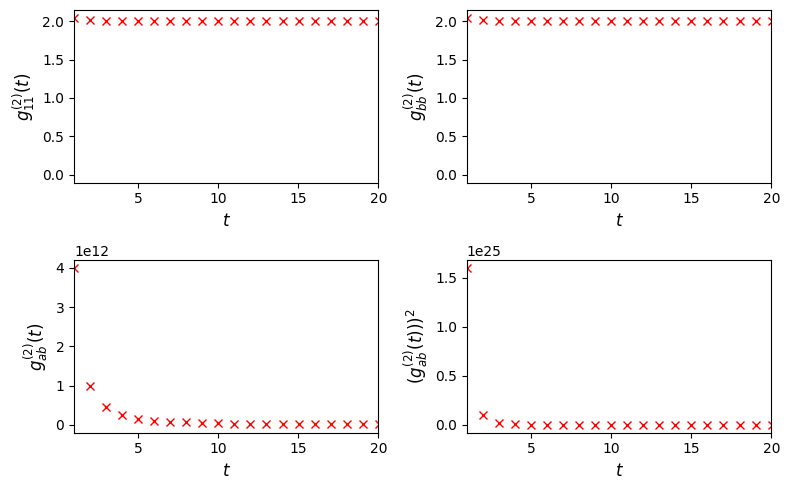

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8,5))
background=1e-30
quantities_dict = {
  "g_aa": [r'$g_{11}^{(2)}(t)$', ((expected_vals_dict["ad_ad_a_a"])/(background**2+expected_vals_dict["na"]**2))], 
  "g_bb": [r'$g_{bb}^{(2)}(t)$', ((expected_vals_dict["bd_bd_b_b"])/(background**2+expected_vals_dict["nb"]**2))],
  "g_ab": [r'$g_{ab}^{(2)}(t)$', ((expected_vals_dict["ad_a_bd_b"])/(background**2+expected_vals_dict["na"]*expected_vals_dict["nb"]))],
  "g_ab_squared": [r'$(g_{ab}^{(2)}(t)))^{2}$', ((expected_vals_dict["ad_a_bd_b"])/(background**2+expected_vals_dict["na"]*expected_vals_dict["nb"]))**2]

}

for idx, (quantity_key, (ylabel, data)) in enumerate(quantities_dict.items()):
    line = axes[idx//2, idx%2].plot(tlist, data, 'rx', linewidth=2)
    axes[idx//2, idx%2].set_xlabel("$t$", fontsize=plot_fontsize)
    axes[idx//2, idx%2].set_xlim(1, 20) # 
    axes[idx//2, idx%2].set_ylabel(ylabel, fontsize=plot_fontsize)
#    axes[idx//2, idx%2].set_yscale("log")


fig.tight_layout()
